# Overview

This notebook provides detailed steps for the reconstruction (including data reduction and morphology reconstruction) of proejct PUP_FF_SOFC_hires3_S2, which was taken place back in 2015.

> NOTE:  
> * Currently, only the first layer (out of seven valid layers) is analyzed.
> * The choice of the first layer is based on the fact that it contains the tip, the poristy of which has significant impact on the FC performance.

## Prepation

Import modules and define user define functions.

In [1]:
# -- import modules
import tomopy
import gc
import numpy   as np
import scipy   as sp
import numexpr as ne

import matplotlib.pyplot as plt

from tqdm import tnrange, tqdm_notebook
from tqdm import trange

from dxchange.reader   import read_aps_1id_metafile
from dxchange.reader   import read_tiff_stack
from dxchange.writer   import write_aps_1id_report
from dxchange.writer   import write_tiff_stack
from dxchange.writer   import write_vtr

from tomopy.prep.alignment import find_slits_corners_aps_1id
from tomopy.prep.alignment import detector_drift_adjust_aps_1id
from tomopy.prep.alignment import remove_slits_aps_1id
from tomopy.prep.normalize import minus_log
from tomopy.misc.npmath    import discrete_cdf
from tomopy.misc.npmath    import gauss1d

from scipy.signal   import medfilt
from scipy.signal   import medfilt2d
# from scipy.signal   import convolve
from scipy.optimize import curve_fit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import shift
from scipy.ndimage import convolve

from scipy.special import erf, erfc

# --
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntProgress
from IPython.display import display

# --
from matplotlib import animation, rc
from IPython.display import HTML, Image

/home/chenz3/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [2]:
# -- svd function
def svd_enhance(img, eigen_cut=20):
    U, S, V = np.linalg.svd(img, full_matrices=True)
    eigen_cut = min(eigen_cut, U.shape[1], V.shape[0]) 
    return np.dot(U[:,:eigen_cut]*S[:eigen_cut], V[:eigen_cut,:])

In [3]:
# -- quick lambda function
val_atPercent = lambda ar, p: np.sort(ar.flatten())[int(np.prod(ar.shape)*p)] 
wgt_histequal = lambda ar: (np.sort(ar.flatten()).searchsorted(ar) + 1)/np.prod(ar.shape)
wgts_binned   = lambda wgts, bins: np.int64(np.floor(wgts * bins)).astype(wgts.dtype) / bins

## Metadata processing

Process/Parse the metadata (auto-generated during scan) to extract

* beam status (various stability)
* frame quality
* connectivity bewteen rotation angle ($\omega$) and the image sequence number
* group layers into dataframes

In [4]:
# ----- CONFIG BLOCK ----- #
# -- change the following based on the sample
metaf1        = "PUP_FF_SOFC_hires3_S2_TomoStillScan.dat"
sampleImgName = "PUP_FF_SOFC_hires3_S2/PUP_FF_SOFC_hires3_S2_000008.tif"
write_base    = "PUP_FF_SOFC_hires3_S2_results/PUP_FF_SOFC_hires3_S2"
reportfn      = "PUP_FF_SOFC_hires3_S2_report/scanSummary.pdf"

# -- reconstruction config
recon_config = {'algorithm': 'gridrec',
                'filter'   : 'hann',
               }

# -- build data frame and generate report
df_layers = write_aps_1id_report(read_aps_1id_metafile(metaf1), reportfn)

layerIDs = df_layers['layerID'].unique()

print(f"Unique layers are: {layerIDs}")

Unique layers are: [ 6  7  8  9 10 11 12]


__manual__ select the first layer, which contains the tip

In [5]:
layerID = 6

df_layern = df_layers[df_layers['layerID'] == layerID]

df_layern.describe()

,num,nSeq,exp,fOmega,Omega,ICint,IC-E1,IC-E2,IC-E3,IC-E4,...,bpEds,LN2temp,SRcurrent,encoderX,seqNum,layerID,TBS,VBS,BLS,BLT
count,3631.000000,3631.000000,3.631000e+03,3631.000000,3631.000000,3.631000e+03,3631.000000,3631.000000,3631.000000,3631.000000,...,3631.000000,3631.000000,3631.000000,3631.0,3631.000000,3631.0,3631.000000,3622.000000,3631.000000,3631.000000
mean,1786.165244,1816.000000,1.500000e-01,-1.487194,-1.487225,6.500000e-01,76380.527403,78185.773891,73212.141283,321.169375,...,-13.517194,84.220476,102.049297,0.0,1815.026990,6.0,0.987991,inf,2.105510,0.006412
std,1048.041119,1048.323741,1.015994e-14,104.810435,104.810434,4.441504e-14,4045.376572,4142.571960,3879.211524,15.836482,...,1.058316,0.003734,0.174000,0.0,1048.324049,0.0,0.052350,NaN,0.110042,0.039903
min,1.000000,1.000000,1.500000e-01,-180.000000,-180.000000,6.500000e-01,0.000000,0.000000,419.000000,284.000000,...,-13.574900,84.211000,101.639000,0.0,1.000000,6.0,0.005654,0.949812,0.000000,0.004191
25%,878.500000,908.500000,1.500000e-01,-92.250000,-92.250050,6.500000e-01,76262.000000,78056.000000,72992.000000,309.000000,...,-13.573100,84.218000,101.927000,0.0,907.500000,6.0,0.985021,0.976874,2.107535,0.004288
50%,1786.000000,1816.000000,1.500000e-01,-1.500000,-1.500080,6.500000e-01,76515.000000,78320.000000,73298.000000,320.000000,...,-13.572800,84.221000,102.052000,0.0,1815.000000,6.0,0.989150,0.977052,2.112055,0.004315
75%,2693.500000,2723.500000,1.500000e-01,89.250000,89.249900,6.500000e-01,76965.000000,78796.000000,73905.000000,334.000000,...,-13.572400,84.223000,102.170000,0.0,2722.500000,6.0,0.997342,0.977191,2.114556,0.004344
max,3601.000000,3631.000000,1.500000e-01,180.000000,180.000000,6.500000e-01,78201.000000,81453.000000,75524.000000,363.000000,...,7.125490,84.230000,102.508000,0.0,3631.000000,6.0,1.019190,inf,2.147057,0.768496


In [9]:
# rotation related quantity (useful for reconstruction)
thetas = np.radians(df_layern.loc[df_layern['type']=='still', 'Omega'].values)
dn = int(np.pi/(thetas[1] - thetas[0]))  # assuming eaqual spacing along omega

## Data reduction

The raw data is way to large for regular computer server to handle, therefore data reduction is necessary before further analysis.

_first, generate necessary folders for subsequent analysis_

In [8]:
%%bash

mkdir -p PUP_FF_SOFC_hires3_S2_report
mkdir -p PUP_FF_SOFC_hires3_S2_results
mkdir -p PUP_FF_SOFC_hires3_S2_runtime

_second, background normalization using collected dark and white field images_

In [9]:
print(f"Reading in tiff images")
flat_pre = read_tiff_stack(sampleImgName, df_layern.loc[df_layern['type'] == 'pre_white',  'nSeq'].values)
flat_pst = read_tiff_stack(sampleImgName, df_layern.loc[df_layern['type'] == 'post_white', 'nSeq'].values)
dark_pst = read_tiff_stack(sampleImgName, df_layern.loc[df_layern['type'] == 'post_dark',  'nSeq'].values)
print(f"=> quick summary of background images for layer_{layerID}:")
print(f"\tPre-flat  image:{flat_pre.shape} as {flat_pre.dtype}")
print(f"\tPost-flat image:{flat_pst.shape} as {flat_pst.dtype}")
print(f"\tPost-dark image:{dark_pst.shape} as {dark_pst.dtype}")

Reading in tiff images
=> quick summary of background images for layer_6:
	Pre-flat  image:(10, 2048, 2048) as uint16
	Post-flat image:(10, 2048, 2048) as uint16
	Post-dark image:(10, 2048, 2048) as uint16


In [10]:
# interactively view the flat field image
# 10 dark, 10 white_pre, 10_white_post

def viz_flat(n):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10),)
    
    axes[0,0].imshow(flat_pre[n,:,:], 'jet')
    axes[0,0].set_title("white field (before)")
    xx,yy = discrete_cdf(flat_pre[n,:,:].flatten(), steps=500)
    axes[1,0].plot(xx,yy)
    axes[1,0].set_yscale('log')
    
    axes[0,1].imshow(flat_pst[n,:,:], 'jet')
    axes[0,1].set_title("white field (after)")
    xx,yy = discrete_cdf(flat_pst[n,:,:].flatten(), steps=500)
    axes[1,1].plot(xx,yy)
    axes[1,1].set_yscale('log')
    
    axes[0,2].imshow(dark_pst[n,:,:], 'jet')
    axes[0,2].set_title("dark field")
    xx,yy = discrete_cdf(dark_pst[n,:,:].flatten(), steps=500)
    axes[1,2].plot(xx,yy)
    axes[1,2].set_yscale('log')

# -- use the template
interactive_plot = interactive(viz_flat, n=(0, flat_pre.shape[0]-1))  # still field

output = interactive_plot.children[-1]
interactive_plot 

interactive(children=(IntSlider(value=4, description='n', max=9), Output()), _dom_classes=('widget-interact',)…

Static view (for non-interacitve notebook mode)

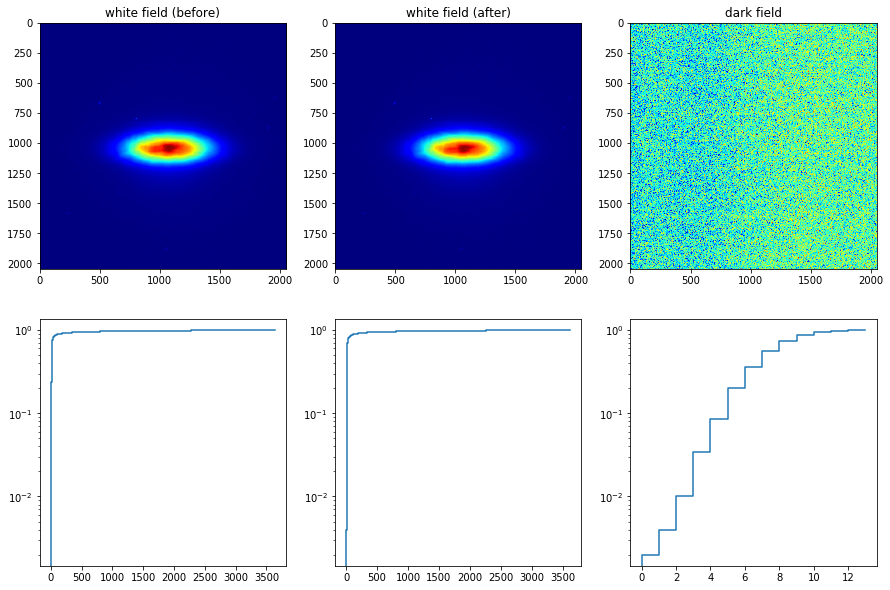

In [11]:
viz_flat(4)

_now, it is time to read in the raw projections_

>NOTE: careful with the memory usage (about __30.0G__ per layer).

In [12]:
projs = read_tiff_stack(sampleImgName, df_layern.loc[df_layern['type'] == 'still',  'nSeq'].values)
print(f"=> quick summary of projection images for layer_{layerID}:")
print(f"\tprojections image:{projs.shape} as {projs.dtype}")

=> quick summary of projection images for layer_6:
	projections image:(3601, 2048, 2048) as uint16


In [13]:
# Interactive view of the projection images

def viz_proj(n):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(projs[n,:,:], 'jet')
    
    xx,yy = discrete_cdf(projs[n,:,:].flatten(), steps=500)
    axes[1].plot(xx,yy)
    axes[1].set_yscale('log')

# -- use the template
interactive_plot = interactive(viz_proj, n=(0, projs.shape[0]-1))  # still field

output = interactive_plot.children[-1]
interactive_plot 

interactive(children=(IntSlider(value=1800, description='n', max=3600), Output()), _dom_classes=('widget-inter…

static view of proejctio images (for non-interactive notebook session)

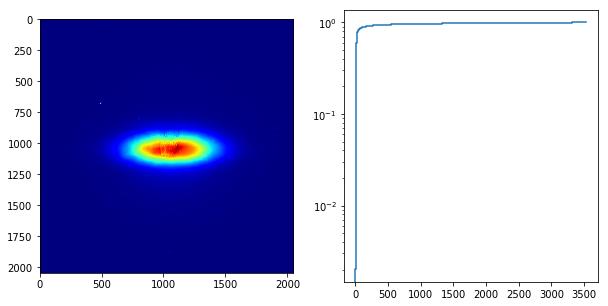

In [14]:
viz_proj(1800)

since the majority of the image is empty, it is better to isolate the region with sample to reduce total data size.

After several interactive visual inspections, the following cropping limit is selected for this layer.

* Layer_6: `img[750:1150, 800:1300]`

### Crop down images

In [16]:
# get the background
bg_white = np.median(flat_pre, axis=0).astype(float)
bg_dark  = np.median(dark_pst, axis=0).astype(float)

In [17]:
bg_white = bg_white[750:1150, 800:1300]
bg_dark  = bg_dark[ 750:1150, 800:1300]
projs    = projs[:, 750:1150, 800:1300]

In [20]:
# remove the background using both white field and dark field

projs_clean = np.zeros(projs.shape)

for n in tqdm_notebook(range(projs.shape[0])):
    img = np.copy(projs[n,:,:]).astype(float)
    img = np.where(img-bg_dark>0, img-bg_dark, 0)
    bg  = np.where(bg_white-bg_dark>0, bg_white-bg_dark, 1)
    img = img/bg
    img = -np.log(np.where(img>0, img, 1))
    projs_clean[n,:,:] = np.where(img>0, img, 0)

In [21]:
# Interactive view of the projection images

def viz_proj(n):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(projs_clean[n,:,:], 'gray')
    
    xx,yy = discrete_cdf(projs_clean[n,:,:].flatten(), steps=500)
    axes[1].plot(xx,yy)

# -- use the template
interactive_plot = interactive(viz_proj, n=(0, projs.shape[0]-1))  # still field

output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=1800, description='n', max=3600), Output()), _dom_classes=('widget-inter…

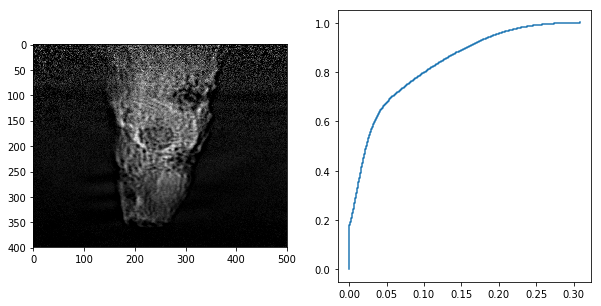

In [22]:
# static view
viz_proj(1800)

__save__ the reduced projections and __restart kernel (manual)__

In [23]:
np.save('PUP_FF_SOFC_hires3_S2_runtime/layer6_projs_reduced', projs_clean)

## Tomography reconstruction

With the reduced data set, it is now possible to perform the reconstruction.

### Counter sample jittering

Due to the experiment setup, significant sample jittering (particularly horizontal one) is present in the data set.
This poses a huge issue to the tomography reconstruction process which requires a common rotation axis for all image.
Consequelty, a phase correlation based correction process, termed "iterative pair-wise adjustment", is used here to counter the __horizontal__ sample jittering by forcing the rotation axis of all iamge to the center of the image.

>Note: Although visible vertical sample jittering is also observed, there is currently no reliable way to counter its impact due to lack of common reference feature.

In [7]:
# load the reduced data set

projs = np.load('PUP_FF_SOFC_hires3_S2_runtime/layer6_projs_reduced.npy')

for n in tqdm_notebook(range(projs.shape[0])):
    projs[n,:,:] /= projs[n,:,:].max()

print(projs.shape)


(3601, 400, 500)


In [10]:
# -- center the data using iterative pairwise adjustment
n_iters     = 10
rot_centers = []

for i in tqdm_notebook(range(n_iters), desc='iter'):
    # adjust the images
    for n_img in tqdm_notebook(range(int(dn)), desc='adjust'):
        # locate the pair-wise center through PC
        _cnt = tomopy.find_center_pc(projs[n_img,:,:], 
                                     projs[n_img+dn,:,:], 
                                     rotc_guess=projs.shape[2]/2,
                                    )
        # adjust the pair images
        # NOTE: 
        #   make sure have order=1 to force using linear interpolation to avoid negative pixels (artifacts)
        val_shift = np.array([0, projs.shape[2]/2 - _cnt])
        projs[n_img,:,:]    = shift(projs[n_img,:,:],    val_shift, mode='constant', cval=0, order=1)
        projs[n_img+dn,:,:] = shift(projs[n_img+dn,:,:], val_shift, mode='constant', cval=0, order=1)
    
    # calculate the average rotation center
    tmp = []
    for n_img in tqdm_notebook(range(int(dn)), desc='calcAvg'):
        tmp.append(tomopy.find_center_pc(projs[n_img,:,:], 
                                         projs[n_img+dn,:,:], 
                                         rotc_guess=projs.shape[2]/2,
                                        )
                  )
    # get the average rotation center
    _cnt = np.average(tmp)
    # if the average rotation center has been adjusted to middle, stop
    if abs(_cnt - projs.shape[2]/2)<0.1:
        break

During the analysis, it was noiticed that there are three corrupted frames, which will add necessary noise to the reconstruction results.
Therefore, the pairs containing corrupted frames are excluded from the reconstruction process.

In [11]:
# -- gather the horizontal jitter profile (rotation center distribution)
dict_rotcnts = {}

thetas = np.radians(df_layern.loc[df_layern['type']=='still', 'Omega'].values)
dn = int(np.pi/(thetas[1] - thetas[0]))  # assuming eaqual spacing along omega

rot_centers = []
for n_img in tqdm_notebook(range(0, int(dn))):
    rot_centers.append(tomopy.find_center_pc(projs[n_img,   :,:], projs[n_img+dn,:,:], rotc_guess=250))

dict_rotcnts['iterPairWiseAdjust'] = rot_centers + rot_centers

# -- find the good/bad frames
rot_cnts = np.array(dict_rotcnts['iterPairWiseAdjust'])

idx_goodimg = np.where(abs(rot_cnts -250)< 1)[0]
idx_badimg  = np.where(abs(rot_cnts -250)>=1)[0]

projs_good  = projs[idx_goodimg,:,:]
thetas_good = thetas[idx_goodimg]
rot_cnt = np.average(rot_cnts[idx_goodimg])

print(projs_good.shape, thetas_good.shape, rot_cnt, np.average(rot_cnts))

(3594, 400, 500) (3594,) 249.99763494713412 249.98625


### counter rotation axis tilt

Prelimenary analysis (see below) indicate that the rotation axis is tilted, which is most likely caused by the mis-alignment between FF detector and the sample rotation stage.
In theory, the most accurate correction would be in-plane rotation to bring the $180^o$-pair into a leveled position. 
However, due to lack of reference points, the exact rotation cannot be deterministically located. 
Therefore, an finite steps apprixmation is used where different rotation center is used for thin slice of data (two sinograms at a time).

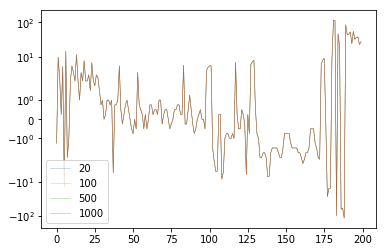

In [12]:
# testing for single pair

nimgs = [20, 100, 500, 1000]
for nimg in nimgs:
    cnts = []
    for nrow in range(0, projs.shape[1], 2):
        cnts.append(tomopy.find_center_pc(projs[n_img,   nrow:nrow+2,:], 
                                          projs[n_img+dn,nrow:nrow+2,:], 
                                          rotc_guess=projs.shape[2]/2,
                                         ) - 250
                   )
    plt.plot(cnts, label=f"{nimg}", linewidth=0.5, alpha=0.5)
    
plt.yscale('symlog')
plt.legend()

In [ ]:
# use slab of 16 pixels
# [32, 16, 8, 4, 2,]

size_slab = 2
recon     = np.zeros((projs.shape[1], projs.shape[2], projs.shape[2]))
rotcnts   = []

for nrow in tqdm_notebook(range(0, projs.shape[1], size_slab), desc='slab'):
    # locate the rotation center 
    _projs  = projs[:,nrow:nrow+size_slab,:]
    _rotcnt = []
    for nimg in tqdm_notebook(range(dn), desc=f'r{nrow}_omega'):
        _rotcnt.append(tomopy.find_center_pc(_projs[nimg,   :,:], 
                                             _projs[nimg+dn,:,:], 
                                             rotc_guess=projs.shape[2]/2,
                                            ),
                      )
    _rotcnt = np.array(_rotcnt + _rotcnt)  # 180 -> 360

    # perform the reconstruction
    recon[nrow:nrow+size_slab,:,:] = tomopy.recon(projs_good[:,nrow:nrow+size_slab,:], 
                                                  thetas_good, 
                                                  center=np.average(_rotcnt[idx_goodimg]),
                                                  algorithm='gridrec', filter_name='hann',
                                                 )
    rotcnts.append(np.average(_rotcnt[idx_goodimg]))

# removal phase artifacts
recon = tomopy.circ_mask(recon, axis=0, ratio=0.6)

phase_recon = tomopy.retrieve_phase(recon,
                                    pixel_size=2e-5,   # 200 nm pixel size on the detector
                                    dist=10,          # the notes said 36m !?
                                    energy=50,         # 45-50 keV, according to existing documentation
                                    )

# output to disk
for n in tqdm_notebook(range(recon.shape[0])):
    
    img  = np.copy(recon[n,:,:])
    pha  = np.absolute(np.copy(phase_recon[n,:,:]))
    pha /= pha.max()

    img -= img.min()
    img /= img.max()
    
    msk  = gaussian_filter(pha, sigma=20) 
    
    recon[n,:,:] = img*msk*255
    
# -- write to disk
write_tiff_stack(recon,
                 overwrite=True,
                 fname=write_base,
                 start=0,
                )

In [ ]:
# quick sanity check
def peekrecon(n):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    
    img = np.copy(recon[n,:,:])
    
    axes[0].imshow(img, 'gray')

    # plot the discrete rotation center
    axes[1].plot(rotcnts)


# -- use the template
interactive_plot = interactive(peekrecon, n=(0, recon.shape[0]-1))  # still field

output = interactive_plot.children[-1]
interactive_plot

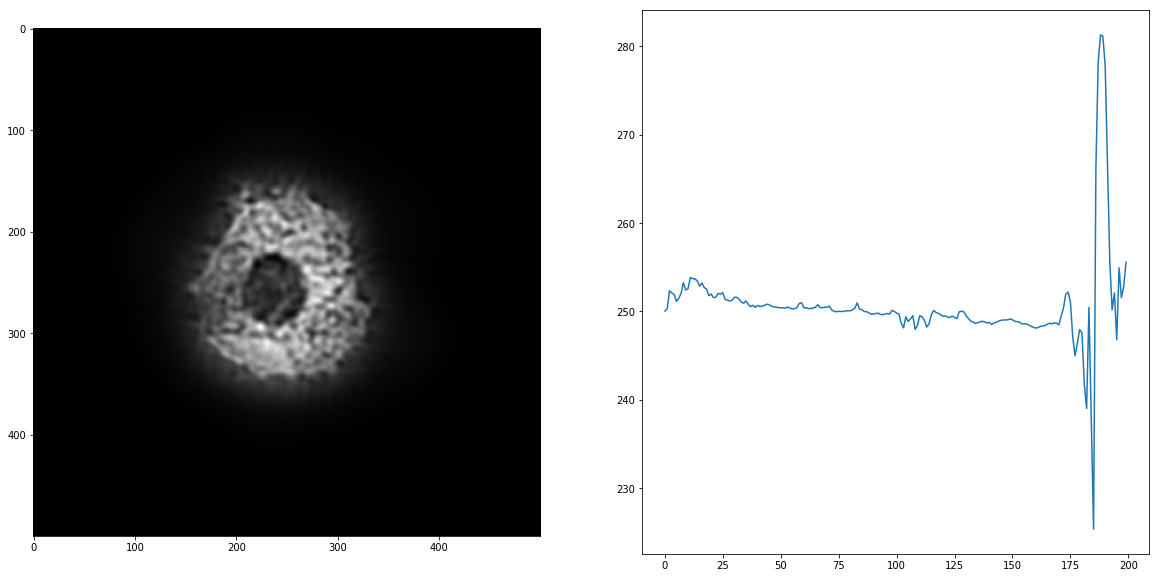

In [15]:
# static view 
peekrecon(199)

## Appendix

List versions of all the modules used in this notebook environment.

> Note: Ensure reproducability of the reconstruction results.

In [13]:
# %load https://gist.github.com/kinverarity1/6038316/raw/loaded_modules.py
'''List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.

'''
# Standard library modules
import types

# Third-party packages
import git      # GitPython
import os


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print(mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


In [14]:
find_loaded_modules().HTML

Name,Version,Path,SHA
git,2.1.11,,
ipywidgets,7.4.2,,
numexpr,2.6.8,,
numpy,1.15.4,,
scipy,1.2.0,,
tomopy,1.3.0,,
